# Self Supervised Data Benchmark Tool

The main objective of this is to be able to create a common assessment tool for any given dataset.

This tool will evaluate the dataset's performance by:
1) Building a classifier on the dataset to generate disease predictions on input images. This classifier is a Deep CNN model.
2) Building an unsupervised ROI generator <sup> * </sup>  : uses contours generated from the opencv library
3) Building the ROI generation using an ensemble model consisting of U-Net, U-Net++, Segnet, FCN & NASnet algorithms.

The metrics generated would be as follows:
1) <u> Classifier </u> : F1 Score, Classification Matrix, Precision, Recall, Accuracy, AUC-ROC
2) <u> Unsupervised ROI generator </u> : Similarity Measures
3) <u> Segmentation </u> : F1 Score, Precision, Recall, DICE

As the datasets used <b> do not </b> have semantic labels to train the U-Net Models on, we would consider Region of Interest generation to be a viable problem.

Author : Harshiv Chandra



<sup> <sup> * </sup> This output shall act as a ground truth for (3) </sup>

# Libraries Needed

In [2]:
# Import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
import pandas as pd
from tensorflow.keras import layers,models
import cv2
import os
import random
from sklearn.cluster import KMeans
from scipy.spatial import distance


# Configuration Options (Advanced Users only)

## Disable Warnings in output

In [3]:
import warnings

warnings.filterwarnings("ignore")

# Required Paths

All the paths to the input csv files are defined here. 

Change these variable values depending on where you run the code.

In [4]:
train_chexpert_path = "train_chexpert.csv"
valid_chexpert_path = "valid_chexpert.csv"
train_covidct_path = "train_covidct.csv"
valid_covidct_path = "valid_covidct.csv"
train_nih_path = "train_nih.csv"
train_lungpet_path = "train_lungpet.csv"

# Dataset PreProcessing

This step deals with loading the image data, parsing it, and processing it for the model appropriately.


We define the following functions for each dataset:

- load_datasetName_values(path)
- generator_datasetName(df,batch_size)



Do note that each dataset has already been split into train.csv and validation.csv respectively.

In [5]:
label_binarizer_chexpert = MultiLabelBinarizer()
label_binarizer_covidct = OneHotEncoder(sparse=False)
#label_binarizer_chexpert = MultiLabelBinarizer()

'''
These functions are used in preprocessing the NIH .csv data
'''
def create_label_mapping(unique_labels):
    """
    returns a label mapping (needed for the NIH dataset)

    input :
        unique_labels : list of labels in the dataset
    output :
        dictionary consisting of key-value mappings in the dataset.
    """
    return {label: idx for idx, label in enumerate(unique_labels)}
def convert_labels_to_integers(labels, label_mapping):
    """
    converts the composite labels present in the NIH dataset to singular integer labels

    input : 
        labels : np.array, the labels in the dataset
        label_mapping : a dictionary consisting of key-value mappings in the dataset
    output :
        integer-based labels for the NIH dataset.
    """
    integer_labels = []
    for label in labels:
        conditions = label.split('|')
        integer_label = [label_mapping[condition] for condition in conditions]
        integer_labels.append(integer_label)
    return integer_labels
def create_one_hot_encoding(labels, label_mapping):
    """
    converts the appropriate textual labels in the NIH dataset directly to one-hot encoded labels.
    
    input : 
        labels : np.array, the labels in the dataset
        label_mapping : a dictionary consisting of key-value mappings in the dataset
    output :
        one-hot-encoded labels for the NIH dataset.
    
    """
    one_hot_encodings = np.zeros((len(labels), len(label_mapping)), dtype=int)
    for i, label in enumerate(labels):
        conditions = label.split('|')
        for condition in conditions:
            one_hot_encodings[i, label_mapping[condition]] = 1
    return one_hot_encodings

'''
The next set of functions is related to loading the dataset .csv files into python for further processing.
'''
def load_chexpert_values(path=train_chexpert_path):
    dataset = pd.read_csv(path)
    print(dataset.shape)
    global label_binarizer_chexpert
    label_binarizer_chexpert.fit(dataset[dataset.columns[5:]].fillna(0).values)
    dataset[dataset.columns[5:]] =  dataset[dataset.columns[5:]].fillna(0).values
    return dataset
def labels_chexpert_titles(path=train_chexpert_path):
    dataset=pd.read_csv(path).columns
    return dataset
def load_covidct_values(path=train_covidct_path):
    dataset = pd.read_csv(path)
    print(dataset.shape)
    global label_binarizer_covidct
    label_binarizer_chexpert.fit(dataset[dataset.columns[5:]].fillna(0).values)
    dataset[dataset.columns[5:]] =  dataset[dataset.columns[5:]].fillna(0).values
    return dataset
def load_nih_values(path=train_nih_path):
    df = pd.read_csv(train_nih_path)
    df = df[df.columns[:2]]
    return df
def load_lungpet_values(path=train_lungpet_path):
    df = pd.read_csv(train_lungpet_path)
    return df


'''
These functions are meant for processing the input images loaded into the model
'''
def resize(img, dims=(256,256)): # input is images
    """
    Simple image resize into the shape you want it to be.
    Default shape set at (256,256) to reduce computational complexity.

    Input:
        img : PIL.Image object, loaded image in memory
        dims : tuple, consisting of the desired widthxheight dimensions of the image

    Output:
        resized image with dimensions 256 x 256 
    """
    return img.resize(dims)# resize_img
def normalise(img):
    '''
    divides the value of each pixel in the input image by 255, to bring it in the range
    of (0,1)

    Input:
        img : PIL.Image object, loaded image in memory

    Output: 
        normalised image with less computational load and less variability amongst pixel values.
    '''
    return img/255# norm_img
def load(image_file):
    """
    read the path given, and open the image.
    Input:
        image_file : str, path to the image
    Output:
        PIL.Image object consisting of the image located at image_file path loaded in the 'RGB' colorspace
    """
    return Image.open(image_file).convert('RGB')

## Classifier's Data Input Utility

In [6]:
covidct_onehot_encoder = OneHotEncoder(sparse=False)
def chexpert_classification_db(path=train_chexpert_path, number_of_samples=20000): # number_of samples is used to determine sample set of dataset to use for training purposes, as a very big set is computationally expensive
    df = load_chexpert_values(path)
    df = df[df.columns].iloc[:number_of_samples]
    # load images into memory
    x = np.asarray([normalise(np.array(resize(load(i[0]))).astype(np.float32)) for i in df[df.columns].values])
    final_col_select = list(df.columns[5:])
    final_col_select.append(df.columns[0])
    df = df[final_col_select]
    y = df[df.columns[:len(df.columns)-1]].values
    # simple y preprocessing
    y = preprocess_y(y)
    return x,y
def preprocess_y(arr):
    arr1 = (arr+1)/2
    arr1 = np.round(arr1).astype(int)
    return arr1
def covidct_classification_db(path=train_covidct_path,number_of_samples=10):
    # CAP - 0, COVID_19 - 1, NORMAL - 2
    df = load_covidct_values(path)[:number_of_samples]
    x = np.asarray([normalise(np.array(resize(load(i[0]))).astype(np.float32)) for i in df[df.columns].values])
    # generate onehotencoded labels
    y = df[df.columns[1]].values
    y = np.asarray(covidct_onehot_encoder.fit_transform(np.reshape(y,(y.shape[0],1))))
    y = preprocess_y(y)
    return x,y  
def nih_classification_db(path=train_nih_path,number_of_samples=15):
    df = load_nih_values(path)[:number_of_samples]
    x = np.asarray([normalise(np.array(resize(load("NIHChestXray/images/"+i[0]))).astype(np.float32)) for i in df[df.columns].values])
    y = df[df.columns[1]].values
    unique_labels = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", 
                     "Pneumonia", "Pneumothorax", "Consolidation", "Edema", "Emphysema", "Fibrosis", 
                     "Pleural_Thickening", "Hernia", "No Finding"]
    label_mapping = create_label_mapping(unique_labels)
    y = create_one_hot_encoding(y, label_mapping)
    return x,y
def lung_classification_db(path=train_lungpet_path,number_of_samples=15):
    df = load_lungpet_values(path)[:number_of_samples]
    x = np.asarray([normalise(np.array(resize(load(i[0]))).astype(np.float32)) for i in df[df.columns].values])
    y = np.asarray(df[df.columns[1:]].values)
    return x,y

## Ensemble Model's Data input utility

In [7]:
def generator_db(df, batch_size):
    """
    Provides a tf.generator object for model to load images from.

    Input : 
        df : DataFrame, consisting of input images and their corresponding ground truth masks.
        batch_size : the number of images you want to pass together, in batches
    Output :
        x : float Tensor, input images to the model
        y : float Tensor, ground truth masks of the model
    """
    print("Loading Dataset...")
    loaded=0
    L = len(df)
    while True:
        print("Loaded ",loaded," images.")
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            loaded_imgs = df[df.columns[0]].iloc[batch_start:limit]
            loaded_imgs = [i.astype(float) for i in loaded_imgs]
            loaded_imgs_masks = df[df.columns[1]].iloc[batch_start:limit]
            loaded_imgs_masks = [i.astype(float) for i in loaded_imgs_masks]
            X = tf.convert_to_tensor(loaded_imgs)
            Y = tf.convert_to_tensor(loaded_imgs_masks)
            yield (X, Y)
            batch_start += batch_size   
            batch_end += batch_size
            loaded+=batch_size
def img_to_df(imgs,masks):
    return pd.DataFrame(list(zip(imgs,masks)))

## Classifier Metrics

In [8]:
def evaluate_model(y_predi, y_test,avg="weighted"):
    """
    Provides metrics for the model on all available classes of the dataset.
    Input : 
        y_test : Array of ground truth labels (encoded in binary format)
        y_pred : Array of predicted model labels (no need for processing)
        avg : str, decides the type of precision, recall and f1 score to be computed.
    Output:
        metrics : A 2D Array, that contains Accuracy, Precision, Recall and F1 scores 
        respectively.
    """
    y_pred = np.around(y_predi)
    acc_score = []
    prec_score = []
    recal_score = []
    fscore = []
    auc_roc_score = []
    for i in range(0,y_test.shape[1]):
        acc_score.append(accuracy_score(y_test[:,i],y_pred[:,i].astype(np.uint8)))
        prec_score.append(precision_score(y_test[:,i],y_pred[:,i].astype(np.uint8),average=avg))
        recal_score.append(recall_score(y_test[:,i],y_pred[:,i].astype(np.uint8),average=avg))
        fscore.append(f1_score(y_test[:,i],y_pred[:,i].astype(np.uint8),average=avg))
        auc_roc_score.append(roc_auc_score(y_test[:,i],y_pred[:,i].astype(np.uint8),average=avg))
    return acc_score,prec_score,recal_score,fscore,auc_roc_score

In [89]:
def plot_fig(history,dataset_nm="",metric='accuracy'):
    rew = [i for i in range(len(history.history.get(metric)))]
    fig = plt.figure()
    rows = 1
    columns =2
    mms = list(history.history.get('val_'+metric))
 #   mms.sort()
    fig.add_subplot(rows, columns, 1) 
    plt.xticks([0,25,50])
    plt.title("TRAIN "+metric.upper())
    plt.plot(rew,history.history.get(metric))
    fig.add_subplot(rows, columns, 2) 
    plt.xticks([0,25,50])
    #plt.yticks([])
    plt.title("VALIDATION "+metric.upper())
    plt.plot(rew,mms)
    plt.tight_layout()
    plt.savefig(metric+"_"+dataset_nm+".png",format="png", dpi=1200)


## Ensemble Metrics

In [9]:
def dice_coefficient(y_true, y_pred):
    return 1 - distance.dice(y_true.flatten(), y_pred.flatten())
def f1(prec,rec):
    return (2*prec*rec)/(prec+rec)
def evaluate_model_seg(y_predi, y_test):
    """
    Provides metrics for the model on all available classes of the dataset.
    Input : 
        y_test : Array of ground truth segmentation labels 
        y_pred : Array of predicted model labels (no need for processing)
    Output:
        metrics : A 2D Array, that contains Accuracy, Precision, Recall and F1 scores 
        respectively.
    """
    y_pred = np.around(y_predi)
    acc_score = accuracy(y_test,y_pred).numpy()
    prec_score = tf.keras.metrics.Precision()
    prec_score.update_state(y_test, y_pred)
    prec_score = prec_score.result().numpy()
    recal_score = tf.keras.metrics.Recall()
    recal_score.update_state(y_test,y_pred)
    recal_score = recal_score.result().numpy()
    fscore=f1(prec_score,recal_score)
    dice_score =dice_coefficient(y_test/np.max(y_test),y_pred)
    return acc_score,prec_score,recal_score,fscore,dice_score
def display_eval_seg(metrics_list):
    metrics_mean = [np.mean(i) for i in metrics_list]
    print("accuracy :",metrics_mean[0])
    print("precision :",metrics_mean[1])
    print("recall :",metrics_mean[2])
    print("f1 score :",metrics_mean[3])
    print("dice score :",metrics_mean[4])

# Classifier Layer

In [10]:
def classifier(input_shape = (256,256,3), num_classes = 14):
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = layers.Conv2D(32, 3, activation='relu')(inputs) #, padding='same'
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(64, 3, activation='relu')(pool1)#, padding='same'
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(128, 3, activation='relu')(pool2)#, padding='same'
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(128, 3, activation='relu')(pool3)#, padding='same'
    conv4 = layers.BatchNormalization()(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    flatten = layers.Flatten()(pool4)
    dense1 = layers.Dense(512, activation='relu')(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense1 = layers.Dropout(0.2)(dense1)
    outputs = layers.Dense(num_classes, activation='sigmoid')(dense1)
    model = models.Model(inputs=inputs, outputs=outputs, name='classifier')

    return model


In [11]:
def display_eval(metrics_list):
    metrics_mean = [np.mean(i) for i in metrics_list]
    print("accuracy :",metrics_mean[0])
    print("precision :",metrics_mean[1])
    print("recall :",metrics_mean[2])
    print("f1 score :",metrics_mean[3])
    print("auc-roc score :",metrics_mean[4])

In [12]:
def accuracy(y_true, y_pred, threshold=0.5):
    y_pred_binary = tf.cast(tf.math.greater_equal(y_pred, threshold), tf.float32)
    correct_predictions = tf.reduce_sum(tf.cast(tf.math.equal(y_true, y_pred_binary), tf.float32))
    total_samples = tf.cast(tf.size(y_true), tf.float32)
    accuracy = correct_predictions / total_samples
    return accuracy

## Chexpert Dataset

In [13]:
x,y = chexpert_classification_db(number_of_samples=2000)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25)

(223414, 19)


In [14]:
chexpert_classifier = classifier(num_classes = y_train.shape[1])

chexpert_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(), accuracy ])

In [15]:
chexpert_classifier.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     2

In [16]:
x_train.shape

(1500, 256, 256, 3)

In [17]:
y_train[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1])

In [18]:
y_train.shape

(1500, 14)

In [19]:
chexpert_hist = chexpert_classifier.fit(x_train,y_train,validation_split=0.1, epochs=50)

Epoch 1/50
43/43 [==============================] - 47s 1s/step - loss: 0.7325 - precision: 0.2082 - recall: 0.5915 - accuracy: 0.5974 - val_loss: 0.8630 - val_precision: 0.1992 - val_recall: 0.4495 - val_accuracy: 0.6337
Epoch 2/50
43/43 [==============================] - 46s 1s/step - loss: 0.4958 - precision: 0.3751 - recall: 0.5787 - accuracy: 0.7878 - val_loss: 1.1237 - val_precision: 0.0973 - val_recall: 0.0887 - val_accuracy: 0.7294
Epoch 3/50
43/43 [==============================] - 46s 1s/step - loss: 0.3578 - precision: 0.5576 - recall: 0.4470 - accuracy: 0.8612 - val_loss: 0.8878 - val_precision: 0.2669 - val_recall: 0.2538 - val_accuracy: 0.7759
Epoch 4/50
43/43 [==============================] - 46s 1s/step - loss: 0.2902 - precision: 0.6752 - recall: 0.4665 - accuracy: 0.8852 - val_loss: 0.6109 - val_precision: 0.5185 - val_recall: 0.1284 - val_accuracy: 0.8462
Epoch 5/50
43/43 [==============================] - 46s 1s/step - loss: 0.2484 - precision: 0.7194 - recall: 0.5

In [38]:
chexpert_hist.history.keys()

dict_keys(['loss', 'precision', 'recall', 'accuracy', 'val_loss', 'val_precision', 'val_recall', 'val_accuracy'])

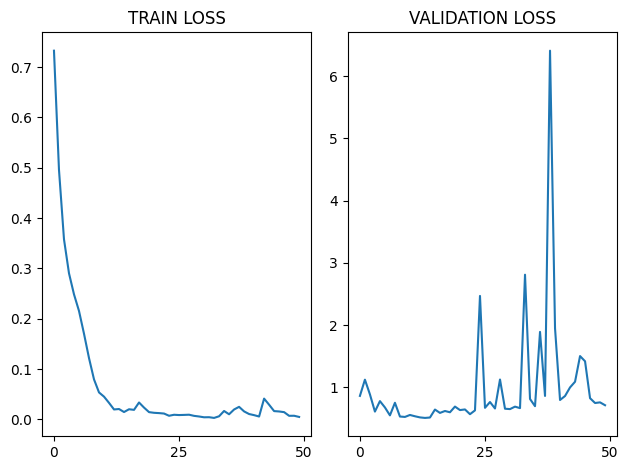

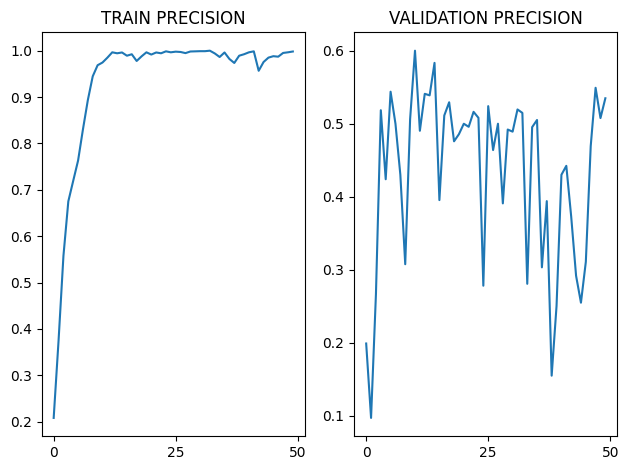

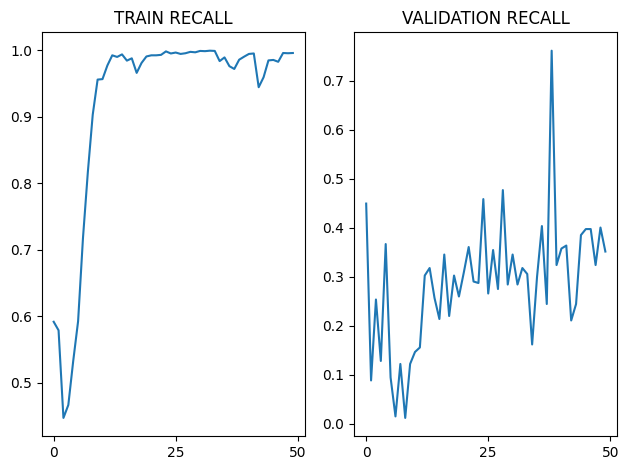

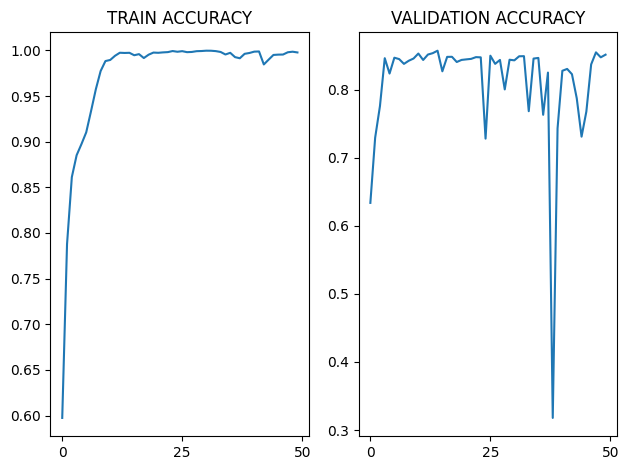

In [94]:
for i in range(0,len(chexpert_hist.history.keys())//2):
    plot_fig(chexpert_hist,dataset_nm="CheXpert",metric=list(chexpert_hist.history.keys())[i])

### Prediction from the classifier model

In [213]:
y_pred = chexpert_classifier.predict(x_test)

16/16 [==============================] - 4s 227ms/step


In [214]:
chexpert_metrics = evaluate_model(y_pred,y_test)

In [220]:
display_eval(chexpert_metrics)

accuracy : 0.952
precision : 0.953039739022648
recall : 0.952
f1 score : 0.9509849152225149
auc-roc score : 0.8736956291653194


## Curated Covid CT

In [62]:
covid_x, covid_y = covidct_classification_db(number_of_samples=2000)
x_train, x_test, y_train, y_test = train_test_split(covid_x,covid_y, test_size=0.25)

(13683, 2)


In [63]:
covidct_classifier = classifier(num_classes=y_train.shape[1])
covidct_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(), accuracy ])

In [64]:
covid_hist = covidct_classifier.fit(x_train,y_train,validation_split=0.1, epochs=50)

Epoch 1/50
43/43 [==============================] - 47s 1s/step - loss: 0.6173 - precision_1: 0.6208 - recall_1: 0.7556 - accuracy: 0.7607 - val_loss: 1.5286 - val_precision_1: 0.4600 - val_recall_1: 0.4600 - val_accuracy: 0.6398
Epoch 2/50
43/43 [==============================] - 46s 1s/step - loss: 0.3419 - precision_1: 0.7893 - recall_1: 0.8296 - accuracy: 0.8677 - val_loss: 2.0459 - val_precision_1: 0.2993 - val_recall_1: 0.5867 - val_accuracy: 0.4057
Epoch 3/50
43/43 [==============================] - 46s 1s/step - loss: 0.2706 - precision_1: 0.8373 - recall_1: 0.8578 - accuracy: 0.8990 - val_loss: 1.3028 - val_precision_1: 0.4222 - val_recall_1: 0.5067 - val_accuracy: 0.6064
Epoch 4/50
43/43 [==============================] - 46s 1s/step - loss: 0.2347 - precision_1: 0.8669 - recall_1: 0.8830 - accuracy: 0.9121 - val_loss: 1.3955 - val_precision_1: 0.4600 - val_recall_1: 0.4600 - val_accuracy: 0.6398
Epoch 5/50
43/43 [==============================] - 46s 1s/step - loss: 0.1818 -

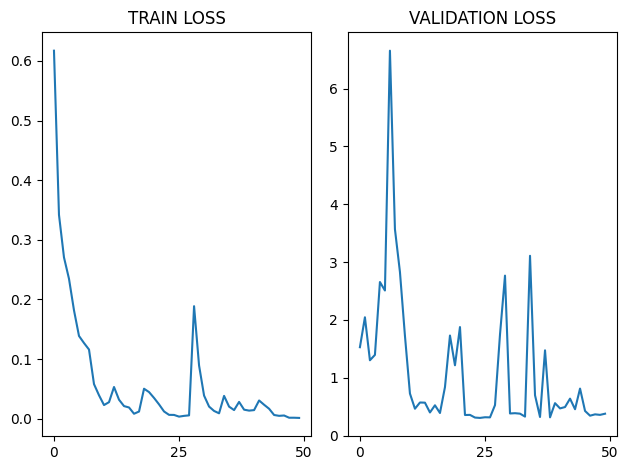

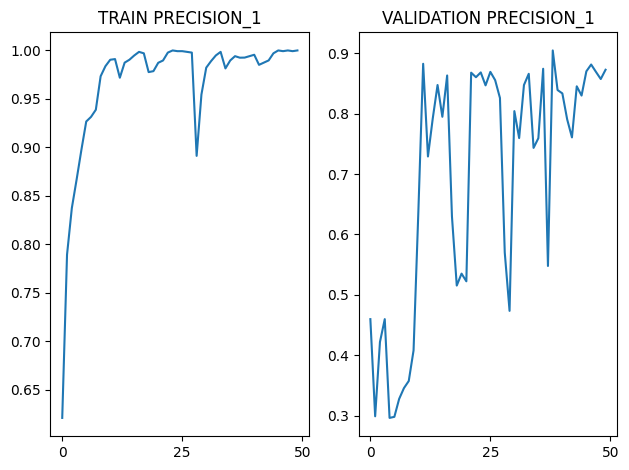

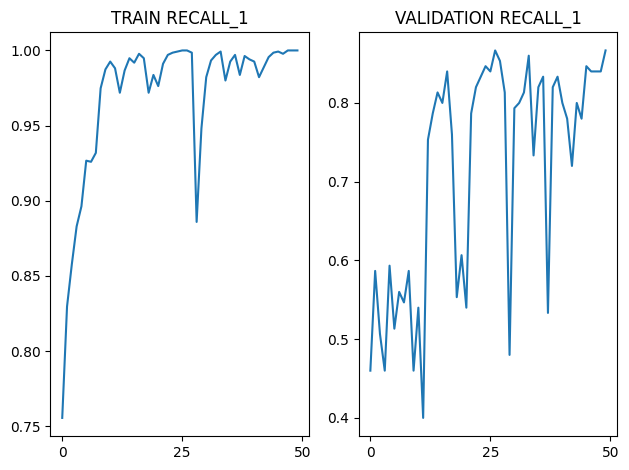

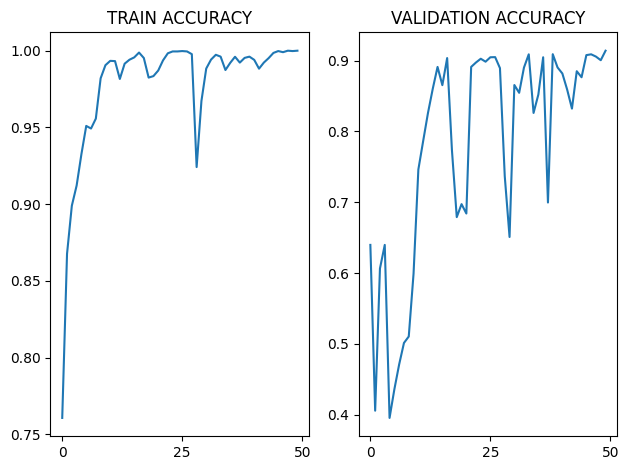

In [91]:
for i in range(0,len(covid_hist.history.keys())//2):
    plot_fig(covid_hist,dataset_nm="CovidCT",metric=list(covid_hist.history.keys())[i])

### Prediction from the classifier model

In [222]:
y_pred = covidct_classifier.predict(x_test)

16/16 [==============================] - 3s 203ms/step


In [224]:
covidct_metrics = evaluate_model(y_pred,y_test)

In [225]:
display_eval(covidct_metrics)

accuracy : 0.96
precision : 0.9617652770205235
recall : 0.96
f1 score : 0.9598385366839897
auc-roc score : 0.9578121446061423


## NIH Chest XRay Data

In [65]:
nih_x, nih_y = nih_classification_db(number_of_samples= 2000)
x_train, x_test, y_train, y_test = train_test_split(nih_x,nih_y, test_size=0.25)

In [66]:
nih_classifier = classifier(num_classes = y_train.shape[1])
nih_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(), accuracy ])

In [67]:
nih_hist = nih_classifier.fit(x_train,y_train,validation_split=0.1,epochs=50)

Epoch 1/50
43/43 [==============================] - 46s 1s/step - loss: 0.7261 - precision_2: 0.1070 - recall_2: 0.5159 - accuracy: 0.6009 - val_loss: 1.0127 - val_precision_2: 0.1096 - val_recall_2: 0.6957 - val_accuracy: 0.5130
Epoch 2/50
43/43 [==============================] - 46s 1s/step - loss: 0.4727 - precision_2: 0.2135 - recall_2: 0.4535 - accuracy: 0.8165 - val_loss: 0.2999 - val_precision_2: 0.4878 - val_recall_2: 0.4348 - val_accuracy: 0.9158
Epoch 3/50
43/43 [==============================] - 45s 1s/step - loss: 0.2868 - precision_2: 0.4759 - recall_2: 0.3312 - accuracy: 0.9140 - val_loss: 0.3019 - val_precision_2: 0.4059 - val_recall_2: 0.4457 - val_accuracy: 0.9007
Epoch 4/50
43/43 [==============================] - 45s 1s/step - loss: 0.2218 - precision_2: 0.5806 - recall_2: 0.3200 - accuracy: 0.9233 - val_loss: 0.2654 - val_precision_2: 0.5600 - val_recall_2: 0.4565 - val_accuracy: 0.9253
Epoch 5/50
43/43 [==============================] - 46s 1s/step - loss: 0.2037 -

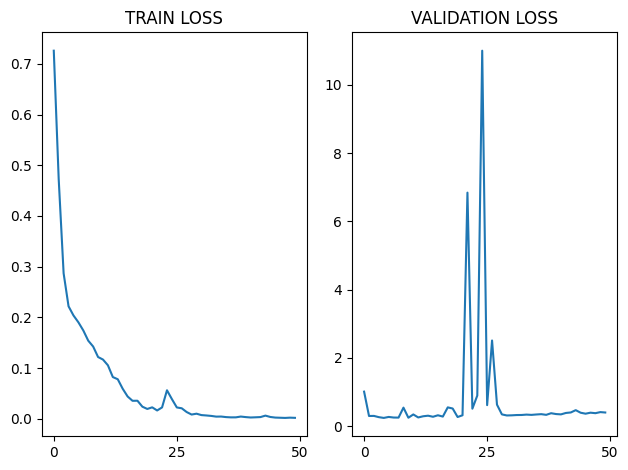

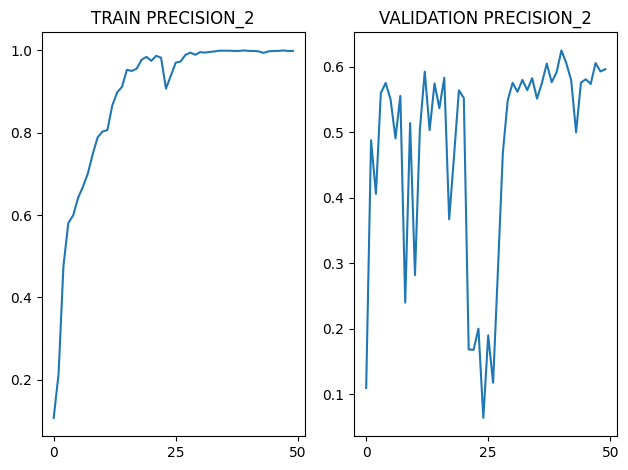

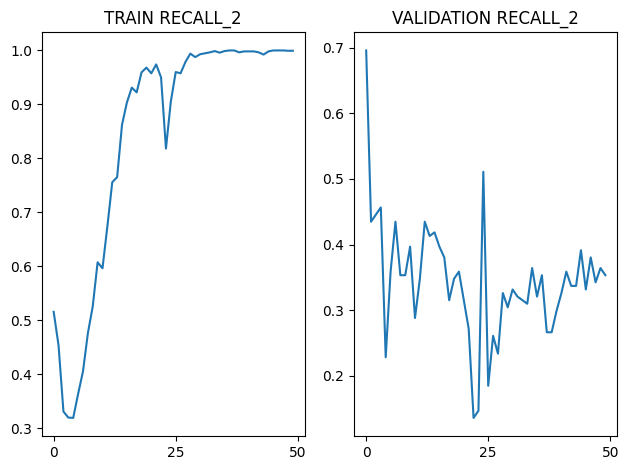

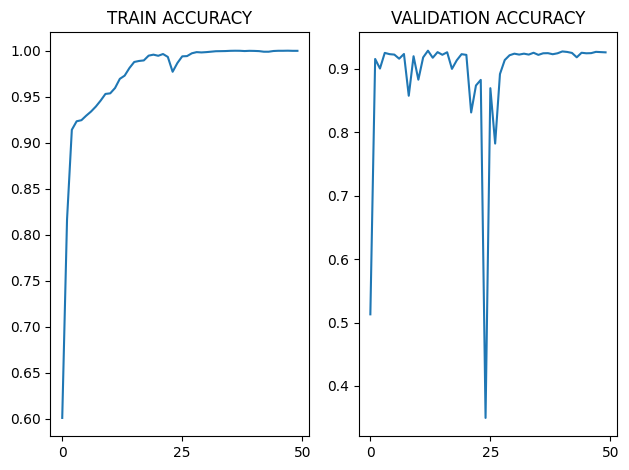

In [93]:
for i in range(0,len(nih_hist.history.keys())//2):
    plot_fig(nih_hist,dataset_nm="NIH",metric=list(nih_hist.history.keys())[i])

### Prediction from the classifier model

In [231]:
y_pred = nih_classifier.predict(x_test)

16/16 [==============================] - 3s 201ms/step


In [232]:
nih_metrics = evaluate_model(y_pred,y_test)

In [233]:
display_eval(nih_metrics)

accuracy : 0.9565333333333332
precision : 0.9563950035231478
recall : 0.9565333333333332
f1 score : 0.954343205974901
auc-roc score : 0.7549401828781914


## Lung PET CT Dx Data

In [68]:
dicom_x, dicom_y = lung_classification_db(number_of_samples=2000)
x_train, x_test, y_train, y_test = train_test_split(dicom_x,dicom_y, test_size=0.25)

In [69]:
lung_classifier = classifier(num_classes = y_train.shape[1])
lung_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(), accuracy ])

In [70]:
lung_hist = lung_classifier.fit(x_train,y_train,validation_split=0.1,epochs=50)

Epoch 1/50
43/43 [==============================] - 46s 1s/step - loss: 0.7770 - precision_3: 0.3356 - recall_3: 0.5541 - accuracy: 0.6145 - val_loss: 0.3620 - val_precision_3: 0.8208 - val_recall_3: 0.5800 - val_accuracy: 0.8626
Epoch 2/50
43/43 [==============================] - 45s 1s/step - loss: 0.4879 - precision_3: 0.5999 - recall_3: 0.6474 - accuracy: 0.8068 - val_loss: 0.3470 - val_precision_3: 0.7600 - val_recall_3: 0.7600 - val_accuracy: 0.8790
Epoch 3/50
43/43 [==============================] - 45s 1s/step - loss: 0.3791 - precision_3: 0.7344 - recall_3: 0.6985 - accuracy: 0.8609 - val_loss: 0.3328 - val_precision_3: 0.7600 - val_recall_3: 0.7600 - val_accuracy: 0.8790
Epoch 4/50
43/43 [==============================] - 45s 1s/step - loss: 0.3276 - precision_3: 0.7498 - recall_3: 0.7215 - accuracy: 0.8703 - val_loss: 0.3619 - val_precision_3: 0.7600 - val_recall_3: 0.7600 - val_accuracy: 0.8790
Epoch 5/50
43/43 [==============================] - 45s 1s/step - loss: 0.3079 -

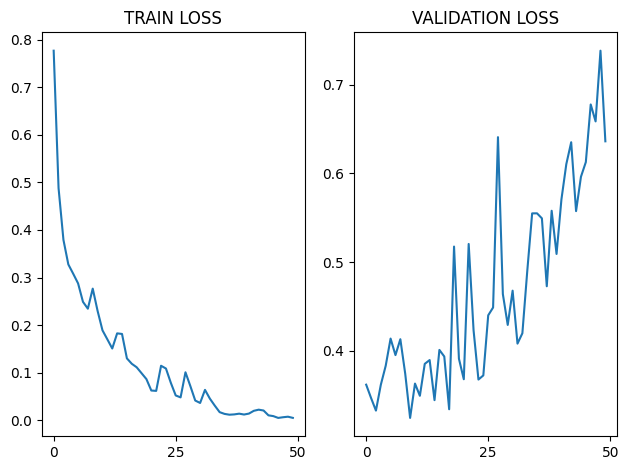

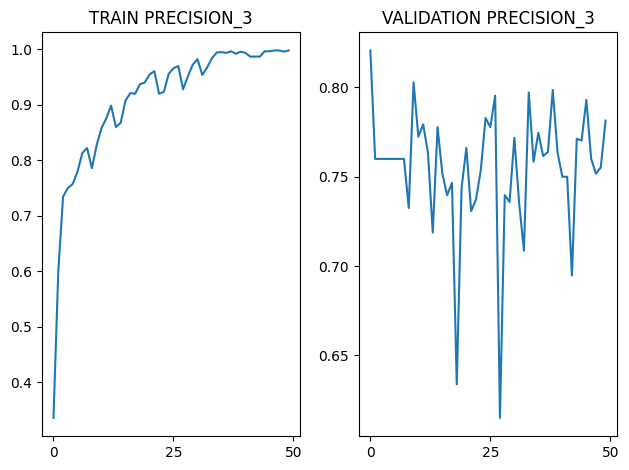

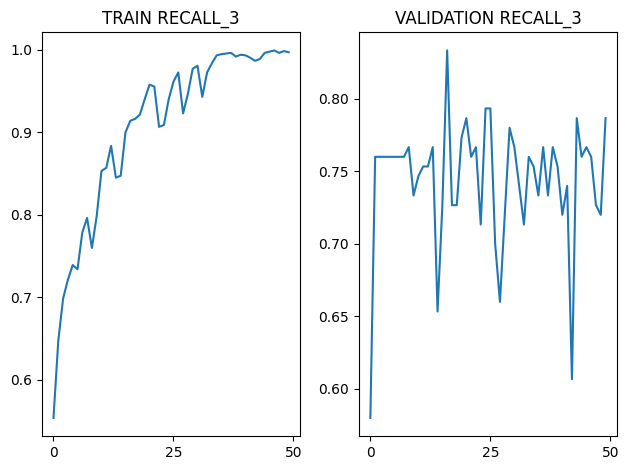

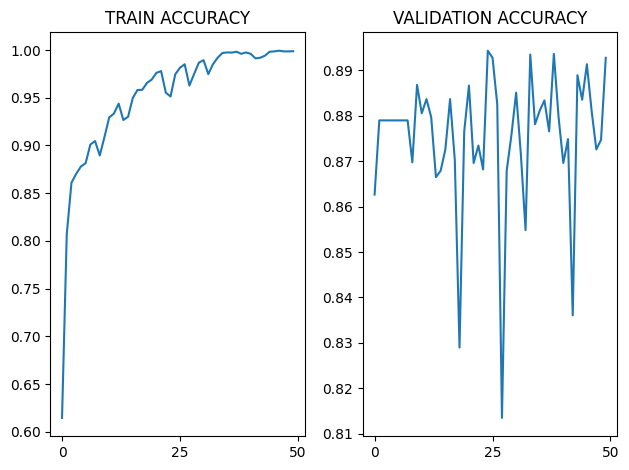

In [95]:
for i in range(0,len(lung_hist.history.keys())//2):
    plot_fig(lung_hist,dataset_nm="Lung",metric=list(lung_hist.history.keys())[i])

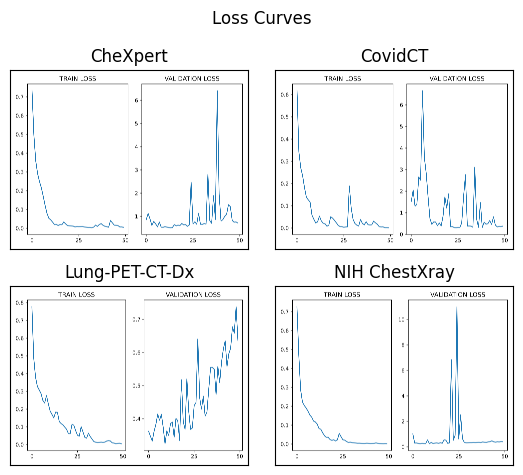

In [104]:
figz = plt.figure()
rows = 2
columns = 2
figz.suptitle("Loss Curves")
figz.add_subplot(rows,columns,1)
plt.xticks([])
plt.yticks([])
plt.title("CheXpert")
plt.imshow(Image.open("loss_CheXpert.png"))
plt.tight_layout()
figz.add_subplot(rows,columns,2)
plt.xticks([])
plt.yticks([])
plt.title("CovidCT")
plt.imshow(Image.open("loss_CovidCT.png"))
plt.tight_layout()
figz.add_subplot(rows,columns,3)
plt.xticks([])
plt.yticks([])
plt.title("Lung-PET-CT-Dx")
plt.imshow(Image.open("loss_Lung.png"))
plt.tight_layout()
figz.add_subplot(rows,columns,4)
plt.xticks([])
plt.yticks([])
plt.title("NIH ChestXray")
plt.imshow(Image.open("loss_NIH.png"))
plt.tight_layout()
figz.tight_layout()
plt.savefig("Loss_Combined.png",format="png", dpi=1200)

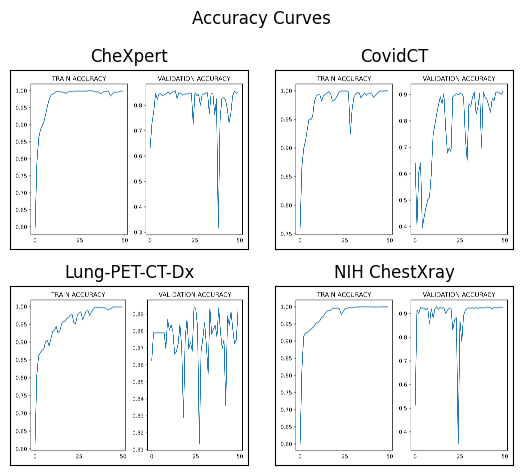

In [105]:
figz = plt.figure()
rows = 2
columns = 2
figz.suptitle("Accuracy Curves")
figz.add_subplot(rows,columns,1)
plt.xticks([])
plt.yticks([])
plt.title("CheXpert")
plt.imshow(Image.open("accuracy_CheXpert.png"))
plt.tight_layout()
figz.add_subplot(rows,columns,2)
plt.xticks([])
plt.yticks([])
plt.title("CovidCT")
plt.imshow(Image.open("accuracy_CovidCT.png"))
plt.tight_layout()
figz.add_subplot(rows,columns,3)
plt.xticks([])
plt.yticks([])
plt.title("Lung-PET-CT-Dx")
plt.imshow(Image.open("accuracy_Lung.png"))
plt.tight_layout()
figz.add_subplot(rows,columns,4)
plt.xticks([])
plt.yticks([])
plt.title("NIH ChestXray")
plt.imshow(Image.open("accuracy_NIH.png"))
plt.tight_layout()
figz.tight_layout()
plt.savefig("Accuracy_Combined.png",format="png", dpi=1200)

### Prediction from the classifier model

In [235]:
y_pred = lung_classifier.predict(x_train)

47/47 [==============================] - 11s 229ms/step


In [236]:
lung_metrics = evaluate_model(y_pred,y_train)

In [237]:
display_eval(lung_metrics)

accuracy : 0.9610000000000001
precision : 0.9601617017513439
recall : 0.9610000000000001
f1 score : 0.9601514176088605
auc-roc score : 0.8615617612215761


# Unsupervised ROI Generator

The Regions of Interest (Aka, the segmentation masks) for each image is generated using a K-Means clustering model.

The K-Means model is used with a unit definition of 4, where each label predicted has the following meaning : 

In [208]:
class cluster:
    """ Used to define the class needed for K-Means clustering data
        This will be used to generate image segmentation for use by the ensemble model
    """ 
    def __init__(cluster, no_units=5):
        cluster.k_means_model = KMeans(n_clusters=no_units,random_state=5)
    def train_and_predict_labels(cluster, dataset ):
        cluster.k_means_model.fit(dataset)
        return cluster.k_means_model.predict(dataset)# maybe, maybe not. will have to check this out later.
    def predict(cluster,dataset):
        return cluster.k_means_model.predict(dataset)
    def model_return(cluster):
        return cluster.k_means_model
    def calculate_cosine_similarity(cluster, dataset):
        centroids = cluster.k_means_model.cluster_centers_
        return cosine_similarity(dataset, centroids)

        
def roi_generation(input_img_arr,dataset_name="chexpert",units=4):
    cluste = cluster(no_units=units)
    generated_imgs = []
    cosine_similarity = []
    for i in input_img_arr:
        load_img = np.asarray(Image.fromarray(np.uint8(i*255)).convert("L"))
        generated_mask = cluste.train_and_predict_labels(np.reshape(load_img,load_img.shape[0]*load_img.shape[1]).reshape(-1,1))
        generated_mask = np.reshape(generated_mask, (load_img.shape[0],load_img.shape[1]))
        generated_imgs.append(generated_mask)     
        cosine_similarity.append(cluste.calculate_cosine_similarity(np.reshape(load_img,load_img.shape[0]*load_img.shape[1]).reshape(-1,1)))
    print("Cosine Similarity:",np.mean(cosine_similarity))
    random_sample = random.randint(0,input_img_arr.shape[0]-1)
    fig = plt.figure()
    rows = 1
    columns =2
    fig.add_subplot(rows, columns, 1) 
    plt.xticks([])
    plt.yticks([])
    plt.title("Processed Input Image")
    plt.imshow(input_img_arr[random_sample])
    fig.add_subplot(rows, columns, 2) 
    plt.xticks([])
    plt.yticks([])
    plt.title("Generated Image Mask")
    plt.imshow(generated_imgs[random_sample])
    plt.tight_layout()
    plt.savefig("ROIgeneration_"+dataset_name+".png",format="png", dpi=1200)
    return input_img_arr, np.asarray(generated_imgs)

(223414, 19)
Cosine Similarity: 0.9879723002115885


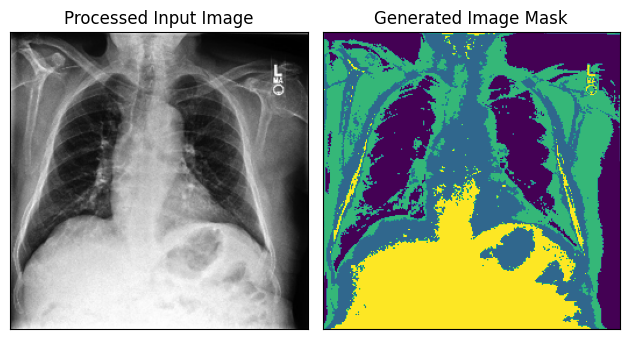

In [211]:
chexpert_imgs, chexpert_masks = roi_generation(chexpert_classification_db(number_of_samples=1500)[0], dataset_name="chexpert",units=4)

(13683, 2)
Cosine Similarity: 0.9149025268554688


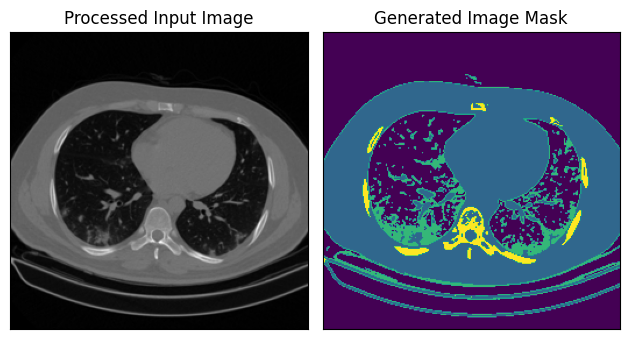

In [212]:
covidct_imgs, covidct_masks = roi_generation(covidct_classification_db(number_of_samples=1500)[0],dataset_name ="covidct")

Cosine Similarity: 0.9807732950846354


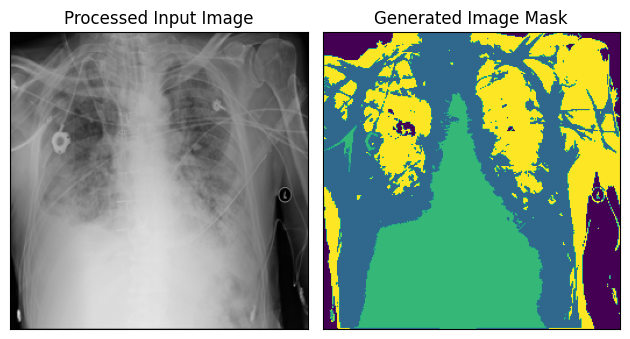

In [213]:
nih_imgs, nih_masks = roi_generation(nih_classification_db(number_of_samples=1500)[0],dataset_name="nih")

Cosine Similarity: 0.7147639465332031


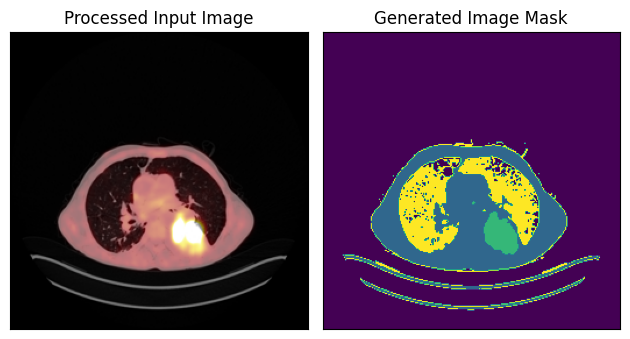

In [210]:
dicom_imgs, dicom_masks = roi_generation(lung_classification_db(number_of_samples=1500)[0],dataset_name="lung-pt")

# Model Definition

In order to be able to construct the heterogeneous ensemble model, we must first define the following models,
- UNet
- SegNet
- FCN
- Mask-R-CNN
- UNet++
- NASNet

In [21]:
def unet(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    up4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = layers.concatenate([up4, conv2], axis=-1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
    up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv1], axis=-1)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
    
def segnet(input_shape=(256, 256, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    up4 = layers.UpSampling2D(size=(2, 2))(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(up4)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv5)
    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv6)
    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(conv6)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
    
def fcn(input_shape=(256, 256, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    up5 = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(conv4)
    up5 = layers.UpSampling2D(size=(2, 2))(up5)
    merge1 = layers.concatenate([up5, conv3], axis=-1)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge1)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv6)
    up7 = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(conv6)
    up7 = layers.UpSampling2D(size=(2, 2))(up7)
    merge2 = layers.concatenate([up7, conv2], axis=-1)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge2)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)
    up9 = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(conv8)
    up9 = layers.UpSampling2D(size=(2, 2))(up9)
    merge3 = layers.concatenate([up9, conv1], axis=-1)
    conv10 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge3)
    conv10 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv10)
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv10)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
    
def conv_block(x, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    x = layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
    x = layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
    return x
    
def upsample_block(x, skip_connection, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    x = layers.Conv2DTranspose(filters, kernel_size, activation=activation, strides=(2, 2), padding=padding)(x)
    x = layers.concatenate([x, skip_connection], axis=-1)
    x = conv_block(x, filters, kernel_size, activation, padding)
    return x
    
def unet_plusplus(input_shape=(256, 256, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = conv_block(inputs, 64)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(pool1, 128)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(pool2, 256)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(pool3, 512)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    up4 = upsample_block(conv4, conv3, 256)
    up3 = upsample_block(up4, conv2, 128)
    up2 = upsample_block(up3, conv1, 64)
    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(up2)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
    


## Experimental Model Definitions 
Note : These models might compile, but have graph execution/misc errors in the train loop

Models stuck in this phase :

- NASNet
- Mask-RCNN


In [ ]:
def nasnet(input_shape=(256, 256, 3), num_classes=4):
    base_model = tf.keras.applications.nasnet.NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    output = layers.Conv2D(1, (1, 1), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=output)
    return model

def mask_rcnn(input_shape=(256, 256, 3), num_classes=1): # using ResNet 50 as backbone, can be swapped for something else.
    inputs = tf.keras.Input(shape=input_shape)
    backbone = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    rpn = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(backbone.output)
    rpn_class = layers.Conv2D(2, (1, 1), activation='softmax', name='rpn_class')(rpn)
    rpn_bbox = layers.Conv2D(4, (1, 1), name='rpn_bbox')(rpn)
    roi_align = layers.TimeDistributed(layers.Masking(mask_value=0))(backbone.output)
    roi_align = layers.TimeDistributed(layers.Conv2D(256, (2,2), activation='relu'))(roi_align)
    roi_pool = layers.TimeDistributed(layers.GlobalAveragePooling2D())(roi_align)
    fc1 = layers.TimeDistributed(layers.Dense(1024, activation='relu'))(roi_pool)
    fc2 = layers.TimeDistributed(layers.Dense(1024, activation='relu'))(fc1)
    class_predictions = layers.TimeDistributed(layers.Dense(num_classes, activation='softmax'), name='mrcnn_class')(fc2)
    bbox_predictions = layers.TimeDistributed(layers.Dense(num_classes * 4, activation='linear'), name='mrcnn_bbox')(fc2)
    model = models.Model(inputs=inputs, outputs=[rpn_class, rpn_bbox, class_predictions, bbox_predictions])
    return model

## Model Execution Step

#### CheXpert 

In [ ]:
model1_chexpert = unet()
model2_chexpert = unet_plusplus()
model3_chexpert = segnet()
model4_chexpert = fcn()

In [ ]:
model1_chexpert.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=['precision','recall','accuracy'])#, run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])
model2_chexpert.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall()])#, run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])
model3_chexpert.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall()])# run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])
model4_chexpert.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall()])#, run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])

#### Covid CT

In [ ]:
model1_covid = unet()
model2_covid = unet_plusplus()
model3_covid = segnet()
model4_covid = fcn()

In [ ]:
model1_covid.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=['precision','recall','accuracy'])#, run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])
model2_covid.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall()])#, run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])
model3_covid.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall()])# run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])
model4_covid.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall()])#, run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])

#### NIH Chest Xray

In [126]:
model1_nih = unet()
model2_nih = unet_plusplus()
model3_nih = segnet()
model4_nih = fcn()

In [127]:
model1_nih.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=['precision','recall','accuracy'])#, run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])
model2_nih.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall()])#, run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])
model3_nih.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall()])# run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])
model4_nih.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall()])#, run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])

#### Lung-PET-CT-Dx

In [128]:
model1_lungpet = unet()
model2_lungpet = unet_plusplus()
model3_lungpet = segnet()
model4_lungpet = fcn()

In [129]:
model1_lungpet.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=['precision','recall','accuracy'])#, run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])
model2_lungpet.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall()])#, run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])
model3_lungpet.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall()])# run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])
model4_lungpet.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall(),accuracy])#,metrics=[tf.keras.metrics.Precision() ,tf.keras.metrics.Recall()])#, run_eagerly=True)#,tf.keras.metrics.IoU,tf.keras.metrics.F1Score])

# Chaining Models together into a heterogeneous ensemble

# Data Loading - CheXpert

In [28]:
x_train, x_test, y_train, y_test = train_test_split(chexpert_imgs,chexpert_masks, test_size=0.25)
train_generator_chexpert = generator_db(img_to_df(x_train.astype(np.float32),y_train.astype(np.float32)),20)

## Some common metrics 

In [29]:
batch_size=20
epochs = 5
steps_epoc = int(len(x_train)/batch_size)

### U-Net

#### optional 

In [ ]:
model1_chexpert.summary()

#### Training & Prediction

In [31]:
model1_chexpert.fit(train_generator_chexpert, batch_size=batch_size,epochs=epochs ,steps_per_epoch=steps_epoc)

Loading Dataset...
Loaded  0  images.
Epoch 1/5
56/56 [==============================] - 500s 9s/step - loss: 1.5188 - precision: 0.7499 - recall: 0.9998 - accuracy: 0.2520
Epoch 2/5
Loaded  1140  images.
56/56 [==============================] - 490s 9s/step - loss: 1.4893 - precision: 0.7499 - recall: 1.0000 - accuracy: 0.2520
Epoch 3/5
56/56 [==============================] - 504s 9s/step - loss: 1.4892 - precision: 0.7499 - recall: 1.0000 - accuracy: 0.2519
Epoch 4/5
56/56 [==============================] - 509s 9s/step - loss: 1.4893 - precision: 0.7499 - recall: 1.0000 - accuracy: 0.2520
Epoch 5/5
56/56 [==============================] - 507s 9s/step - loss: 1.4893 - precision: 0.7499 - recall: 1.0000 - accuracy: 0.2519


In [32]:
y_pred = model1_chexpert.predict(x_test)

12/12 [==============================] - 42s 3s/step


In [71]:
chexpert_unet=evaluate_model_seg(y_pred.squeeze(),y_test)

In [72]:
display_eval_seg(chexpert_unet)

accuracy : 0.2518621
precision : 0.7501221
recall : 1.0
f1 score : 0.8572225709702169
dice score : 0.6654213398852609


### U-Net ++

#### optional

In [ ]:
model2_chexpert.summary()

In [101]:
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model2_chexpert.save("EnsembleModelSaves/UNetpp/unetpp_"+dt_string+".keras")

#### Training & Prediction

In [73]:
model2_chexpert.fit(train_generator_chexpert, epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 677s 12s/step - loss: 1.5214 - precision_1: 0.7499 - recall_1: 0.9999 - accuracy: 0.2519
Epoch 2/5
56/56 [==============================] - 691s 12s/step - loss: 1.4891 - precision_1: 0.7501 - recall_1: 1.0000 - accuracy: 0.2521
Epoch 3/5
56/56 [==============================] - 692s 12s/step - loss: 1.4893 - precision_1: 0.7499 - recall_1: 1.0000 - accuracy: 0.2519
Epoch 4/5
56/56 [==============================] - 695s 12s/step - loss: 1.4892 - precision_1: 0.7499 - recall_1: 1.0000 - accuracy: 0.2519
Epoch 5/5
56/56 [==============================] - 690s 12s/step - loss: 1.4897 - precision_1: 0.7499 - recall_1: 1.0000 - accuracy: 0.2517


In [74]:
y_pred = model2_chexpert.predict(x_test)

12/12 [==============================] - 59s 5s/step


In [75]:
chexpert_unet_pp = evaluate_model_seg(y_pred.squeeze(),y_test)

In [76]:
display_eval_seg(chexpert_unet_pp)

accuracy : 0.2518621
precision : 0.7501221
recall : 1.0
f1 score : 0.8572225709702169
dice score : 0.6654213398852609


### SegNet

#### optional

In [80]:
model3_chexpert.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 128, 128)     147584    
                                                           

In [103]:
from datetime import datetime
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model3_chexpert.save("EnsembleModelSaves/SegNet/segnet_"+dt_string+".keras")

#### Training & Prediction

In [81]:
segnet_history = model3_chexpert.fit(train_generator_chexpert,epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 537s 10s/step - loss: 1.5157 - precision_2: 0.7498 - recall_2: 0.9825 - accuracy: 0.2516
Epoch 2/5
56/56 [==============================] - 543s 10s/step - loss: 1.4891 - precision_2: 0.7499 - recall_2: 1.0000 - accuracy: 0.2520
Epoch 3/5
56/56 [==============================] - 543s 10s/step - loss: 1.4891 - precision_2: 0.7499 - recall_2: 1.0000 - accuracy: 0.2520
Epoch 4/5
56/56 [==============================] - 543s 10s/step - loss: 1.4893 - precision_2: 0.7499 - recall_2: 1.0000 - accuracy: 0.2519
Epoch 5/5
56/56 [==============================] - 550s 10s/step - loss: 1.4892 - precision_2: 0.7500 - recall_2: 1.0000 - accuracy: 0.2520


In [82]:
y_pred = model3_chexpert.predict(x_test)

12/12 [==============================] - 43s 4s/step


In [84]:
chexpert_segnet = evaluate_model_seg(y_pred.squeeze(),y_test)

In [85]:
display_eval_seg(chexpert_segnet)

accuracy : 0.2518621
precision : 0.7501221
recall : 1.0
f1 score : 0.8572225709702169
dice score : 0.6654213398852609


### FCN

#### optional

In [ ]:
model4_chexpert.summary()

In [105]:
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model1.save("EnsembleModelSaves/FCN/fcn_"+dt_string+".keras")

#### Training & Prediction

In [86]:
fcn_history =model4_chexpert.fit(train_generator_chexpert,epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 674s 12s/step - loss: 1.4892 - precision_3: 0.7500 - recall_3: 1.0000 - accuracy: 0.2520
Epoch 2/5
56/56 [==============================] - 674s 12s/step - loss: 1.4891 - precision_3: 0.7498 - recall_3: 1.0000 - accuracy: 0.2519
Epoch 3/5
56/56 [==============================] - 672s 12s/step - loss: 1.4891 - precision_3: 0.7499 - recall_3: 1.0000 - accuracy: 0.2520
Epoch 4/5
56/56 [==============================] - 671s 12s/step - loss: 1.4892 - precision_3: 0.7499 - recall_3: 1.0000 - accuracy: 0.2519
Epoch 5/5
56/56 [==============================] - 674s 12s/step - loss: 1.4888 - precision_3: 0.7499 - recall_3: 1.0000 - accuracy: 0.2520


In [87]:
y_pred = model4_chexpert.predict(x_test)

12/12 [==============================] - 58s 5s/step


In [89]:
chexpert_FCN = evaluate_model_seg(y_pred.squeeze(),y_test)

In [90]:
display_eval_seg(chexpert_FCN)

accuracy : 0.2518621
precision : 0.7501221
recall : 1.0
f1 score : 0.8572225709702169
dice score : 0.6654213398852609


## Ensemble Model for all the above 

In [94]:
ensemble_chexpert = VotingClassifier(estimators=[('unet', model1_chexpert), ('unet++', model2_chexpert), ('segnet', model3_chexpert), ('fcn', model4_chexpert)], voting='hard')

In [ ]:
chexpert_ensemble = evaluate_model_seg(y_pred,y_test)

In [189]:
chexpert_ensemble = [chexpert_FCN[i]+ chexpert_segnet[i]+chexpert_unet_pp[i]+chexpert_unet[i] for i in range(len(chexpert_FCN))]

In [190]:
display_eval_seg(np.asarray(chexpert_ensemble)/4)

accuracy : 0.251862108707428
precision : 0.7501220703125
recall : 1.0
f1 score : 0.8572225709702169
dice score : 0.6654213398852609


# Data Loading - Covidct

In [96]:
x_train, x_test, y_train, y_test = train_test_split(covidct_imgs,covidct_masks, test_size=0.25)
train_generator_covid = generator_db(img_to_df(x_train.astype(np.float32),y_train.astype(np.float32)),20)

## Some Common Metrics

In [97]:
batch_size=20
epochs = 5
steps_epoc = int(len(x_train)/batch_size)

### U-Net

#### optional 

In [98]:
model1_covid.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_54[0][0]']              
                                )                                                           

#### Training & Prediction

In [99]:
model1_covid.fit(train_generator_covid, batch_size=batch_size,epochs=epochs ,steps_per_epoch=steps_epoc)

Loading Dataset...
Loaded  0  images.
Epoch 1/5
56/56 [==============================] - 496s 9s/step - loss: 0.8617 - precision_4: 0.6114 - recall_4: 0.9988 - accuracy: 0.3566
Epoch 2/5
Loaded  1140  images.
56/56 [==============================] - 604s 11s/step - loss: 0.8580 - precision_4: 0.6117 - recall_4: 1.0000 - accuracy: 0.3559
Epoch 3/5
56/56 [==============================] - 1133s 20s/step - loss: 0.8568 - precision_4: 0.6112 - recall_4: 1.0000 - accuracy: 0.3571
Epoch 4/5
56/56 [==============================] - 1107s 20s/step - loss: 0.8566 - precision_4: 0.6108 - recall_4: 1.0000 - accuracy: 0.3559
Epoch 5/5
56/56 [==============================] - 1092s 19s/step - loss: 0.8580 - precision_4: 0.6104 - recall_4: 1.0000 - accuracy: 0.3555


In [100]:
y_pred = model1_covid.predict(x_test)

12/12 [==============================] - 103s 9s/step


In [101]:
covid_unet=evaluate_model_seg(y_pred.squeeze(),y_test)

In [102]:
display_eval_seg(covid_unet)

accuracy : 0.33834136
precision : 0.6202649
recall : 1.0
f1 score : 0.7656339311879022
dice score : 0.4937280499420025


### U-Net ++

#### optional

In [103]:
model2_covid.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_65 (Conv2D)             (None, 256, 256, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_65[0][0]']              
                                )                                                           

In [104]:
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model2_covid.save("EnsembleModelSaves/UNetpp/unetpp_"+dt_string+".keras")

NameError: name 'datetime' is not defined

#### Training & Prediction

In [105]:
model2_covid.fit(train_generator_covid, epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 692s 12s/step - loss: 0.8663 - precision_5: 0.6101 - recall_5: 0.9815 - accuracy: 0.3556
Epoch 2/5
56/56 [==============================] - 684s 12s/step - loss: 0.8555 - precision_5: 0.6097 - recall_5: 1.0000 - accuracy: 0.3558
Epoch 3/5
56/56 [==============================] - 693s 12s/step - loss: 0.8545 - precision_5: 0.6102 - recall_5: 1.0000 - accuracy: 0.3571
Epoch 4/5
56/56 [==============================] - 703s 13s/step - loss: 0.8573 - precision_5: 0.6112 - recall_5: 1.0000 - accuracy: 0.3562
Epoch 5/5
56/56 [==============================] - 706s 13s/step - loss: 0.8589 - precision_5: 0.6119 - recall_5: 1.0000 - accuracy: 0.3563


In [106]:
y_pred = model2_covid.predict(x_test)

12/12 [==============================] - 61s 5s/step


In [107]:
covid_unet_pp = evaluate_model_seg(y_pred.squeeze(),y_test)

In [108]:
display_eval_seg(covid_unet_pp)

accuracy : 0.33834136
precision : 0.6202649
recall : 1.0
f1 score : 0.7656339311879022
dice score : 0.4937280499420025


### SegNet

#### optional

In [ ]:
model3_covid.summary()

In [ ]:
from datetime import datetime
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model3_covid.save("EnsembleModelSaves/SegNet/segnet_"+dt_string+".keras")

#### Training & Prediction

In [110]:
segnet_history = model3_covid.fit(train_generator_covid,epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 551s 10s/step - loss: 0.8686 - precision_6: 0.6112 - recall_6: 0.9853 - accuracy: 0.3555
Epoch 2/5
56/56 [==============================] - 551s 10s/step - loss: 0.8590 - precision_6: 0.6110 - recall_6: 1.0000 - accuracy: 0.3553
Epoch 3/5
56/56 [==============================] - 551s 10s/step - loss: 0.8577 - precision_6: 0.6105 - recall_6: 1.0000 - accuracy: 0.3559
Epoch 4/5
56/56 [==============================] - 549s 10s/step - loss: 0.8576 - precision_6: 0.6111 - recall_6: 1.0000 - accuracy: 0.3561
Epoch 5/5
56/56 [==============================] - 549s 10s/step - loss: 0.8557 - precision_6: 0.6116 - recall_6: 1.0000 - accuracy: 0.3568


In [111]:
y_pred = model3_covid.predict(x_test)

12/12 [==============================] - 41s 3s/step


In [113]:
covid_segnet = evaluate_model_seg(y_pred.squeeze(),y_test)

In [114]:
display_eval_seg(covid_segnet)

accuracy : 0.33834136
precision : 0.6202649
recall : 1.0
f1 score : 0.7656339311879022
dice score : 0.4937280499420025


#### optional

In [ ]:
model4_chexpert.summary()

In [ ]:
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model1.save("EnsembleModelSaves/FCN/fcn_"+dt_string+".keras")

#### Training & Prediction

In [ ]:
fcn_history =model4.fit(train_generator_chexpert,epochs=5,steps_per_epoch=steps_epoc)

In [ ]:
y_pred = model4_chexpert.predict(x_test)

In [ ]:
chexpert_FCN = evaluate_model_seg(y_pred,y_test)

In [ ]:
display_eval_seg(chexpert_FCN)

### FCN

#### optional

In [ ]:
model4_covid.summary()

In [ ]:
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model4_covid.save("EnsembleModelSaves/FCN/fcn_"+dt_string+".keras")

#### Training & Prediction

In [115]:
fcn_history =model4_covid.fit(train_generator_chexpert,epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 710s 13s/step - loss: 1.4888 - precision_7: 0.7499 - recall_7: 1.0000 - accuracy: 0.2520
Epoch 2/5
56/56 [==============================] - 687s 12s/step - loss: 1.4895 - precision_7: 0.7498 - recall_7: 1.0000 - accuracy: 0.2518
Epoch 3/5
56/56 [==============================] - 685s 12s/step - loss: 1.4892 - precision_7: 0.7499 - recall_7: 1.0000 - accuracy: 0.2520
Epoch 4/5
56/56 [==============================] - 695s 12s/step - loss: 1.4896 - precision_7: 0.7500 - recall_7: 1.0000 - accuracy: 0.2519
Epoch 5/5
56/56 [==============================] - 697s 12s/step - loss: 1.4891 - precision_7: 0.7499 - recall_7: 1.0000 - accuracy: 0.2520


In [116]:
y_pred = model4_covid.predict(x_test)

12/12 [==============================] - 61s 5s/step


In [117]:
covid_FCN = evaluate_model_seg(y_pred.squeeze(),y_test)

In [118]:
display_eval_seg(covid_FCN)

accuracy : 0.33834136
precision : 0.6202649
recall : 1.0
f1 score : 0.7656339311879022
dice score : 0.4937280499420025


## Ensemble Model for all the above 

In [136]:
ensemble_covid = VotingClassifier(estimators=[('unet', model1_covid), ('unet++', model2_covid), ('segnet', model3_covid), ('fcn', model4_covid)], voting='soft')

In [ ]:
y_pred = ensemble_covid.predict(x_test)

In [ ]:
covid_ensemble = evaluate_model_seg(y_pred,y_test)

In [187]:
covid_ensemble = [covid_FCN[i]+covid_segnet[i]+covid_unet_pp[i]+covid_unet[i] for i in range(len(nih_FCN))]

In [188]:
display_eval_seg(np.asarray(covid_ensemble)/4)

accuracy : 0.3383413553237915
precision : 0.6202648878097534
recall : 1.0
f1 score : 0.7656339311879022
dice score : 0.4937280499420025


# Data Loading - NIH Chest X-Ray

In [136]:
x_train, x_test, y_train, y_test = train_test_split(nih_imgs,nih_masks, test_size=0.25)
train_generator_nih = generator_db(img_to_df(x_train.astype(np.float32),y_train.astype(np.float32)),20)

## Some Common Metrics

In [137]:
batch_size=20
epochs = 5
steps_epoc = int(len(x_train)/batch_size)

### U-Net

#### optional 

In [ ]:
model1_covid.summary()

#### Training & Prediction

In [31]:
model1_covid.fit(train_generator_covid, batch_size=batch_size,epochs=epochs ,steps_per_epoch=steps_epoc)

Loading Dataset...
Loaded  0  images.
Epoch 1/5
56/56 [==============================] - 500s 9s/step - loss: 1.5188 - precision: 0.7499 - recall: 0.9998 - accuracy: 0.2520
Epoch 2/5
Loaded  1140  images.
56/56 [==============================] - 490s 9s/step - loss: 1.4893 - precision: 0.7499 - recall: 1.0000 - accuracy: 0.2520
Epoch 3/5
56/56 [==============================] - 504s 9s/step - loss: 1.4892 - precision: 0.7499 - recall: 1.0000 - accuracy: 0.2519
Epoch 4/5
56/56 [==============================] - 509s 9s/step - loss: 1.4893 - precision: 0.7499 - recall: 1.0000 - accuracy: 0.2520
Epoch 5/5
56/56 [==============================] - 507s 9s/step - loss: 1.4893 - precision: 0.7499 - recall: 1.0000 - accuracy: 0.2519


In [32]:
y_pred = model1_covid.predict(x_test)

12/12 [==============================] - 42s 3s/step


In [71]:
covid_unet=evaluate_model_seg(y_pred.squeeze(),y_test)

In [72]:
display_eval_seg(covid_unet)

accuracy : 0.2518621
precision : 0.7501221
recall : 1.0
f1 score : 0.8572225709702169
dice score : 0.6654213398852609


### U-Net ++

#### optional

In [ ]:
model2_covid.summary()

In [101]:
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model2_covid.save("EnsembleModelSaves/UNetpp/unetpp_"+dt_string+".keras")

#### Training & Prediction

In [ ]:
model2_covid.fit(train_generator_covid, epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 677s 12s/step - loss: 1.5214 - precision_1: 0.7499 - recall_1: 0.9999 - accuracy: 0.2519
Epoch 2/5
48/56 [========================>.....] - ETA: 1:38 - loss: 1.4893 - precision_1: 0.7500 - recall_1: 1.0000 - accuracy: 0.2519

In [ ]:
y_pred = model2_covid.predict(x_test)

In [ ]:
covid_unet_pp = evaluate_model_seg(y_pred.squeeze(),y_test)

In [ ]:
display_eval_seg(covid_unet_pp)

### SegNet

#### optional

In [ ]:
model3_covid.summary()

In [103]:
from datetime import datetime
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model3_covid.save("EnsembleModelSaves/SegNet/segnet_"+dt_string+".keras")

#### Training & Prediction

In [102]:
segnet_history = model3_covid.fit(train_generator_covid,epochs=5,steps_per_epoch=steps_epoc)

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_447 (Conv2D)         (None, 256, 256, 64)      1792      
                                                                 
 conv2d_448 (Conv2D)         (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_98 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_449 (Conv2D)         (None, 128, 128, 128)     73856     
                                                                 
 conv2d_450 (Conv2D)         (None, 128, 128, 128)     147584    
                                                          

In [ ]:
y_pred = model3_covid.predict(x_test)

In [ ]:
covid_segnet = evaluate_model_seg(y_pred,y_test)

In [ ]:
display_eval_seg(covid_segnet)

### FCN

#### optional

In [ ]:
model4_covid.summary()

In [105]:
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model4_covid.save("EnsembleModelSaves/FCN/fcn_"+dt_string+".keras")

#### Training & Prediction

In [104]:
fcn_history =model4_covid.fit(train_generator_chexpert,epochs=5,steps_per_epoch=steps_epoc)

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_460 (Conv2D)            (None, 256, 256, 64  1792        ['input_39[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_461 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_460[0][0]']             
                                )                                                          

In [ ]:
y_pred = model4_covid.predict(x_test)

In [ ]:
covid_FCN = evaluate_model_seg(y_pred,y_test)

In [ ]:
display_eval_seg(covid_FCN)

### U-Net

#### optional 

In [ ]:
model1_nih.summary()

#### Training & Prediction

In [134]:
x_train.shape

(11, 256, 256, 3)

In [138]:
model1_nih.fit(train_generator_nih, batch_size=batch_size,epochs=epochs ,steps_per_epoch=steps_epoc)

Loading Dataset...
Loaded  0  images.
Epoch 1/5
56/56 [==============================] - 1833s 33s/step - loss: 1.4819 - precision_36: 0.7306 - recall_31: 0.9840 - accuracy: 0.2556
Epoch 2/5
Loaded  1140  images.
56/56 [==============================] - 1711s 31s/step - loss: 1.4512 - precision_36: 0.7304 - recall_31: 1.0000 - accuracy: 0.2547
Epoch 3/5
56/56 [==============================] - 708s 13s/step - loss: 1.4510 - precision_36: 0.7303 - recall_31: 1.0000 - accuracy: 0.2549
Epoch 4/5
56/56 [==============================] - 717s 13s/step - loss: 1.4507 - precision_36: 0.7302 - recall_31: 1.0000 - accuracy: 0.2547
Epoch 5/5
56/56 [==============================] - 712s 13s/step - loss: 1.4518 - precision_36: 0.7305 - recall_31: 1.0000 - accuracy: 0.2545


In [139]:
y_pred = model1_nih.predict(x_test)

12/12 [==============================] - 49s 4s/step


In [140]:
nih_unet=evaluate_model_seg(y_pred.squeeze(),y_test)

In [141]:
display_eval_seg(nih_unet)

accuracy : 0.24086943
precision : 0.72754127
recall : 1.0
f1 score : 0.8422852831413586
dice score : 0.6521211609765574


### U-Net ++

#### optional

In [ ]:
model2_nih.summary()

In [101]:
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model2_nih.save("EnsembleModelSaves/UNetpp/unetpp_"+dt_string+".keras")

#### Training & Prediction

In [142]:
model2_nih.fit(train_generator_nih, epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 891s 16s/step - loss: 1.4820 - precision_37: 0.7305 - recall_32: 1.0000 - accuracy: 0.2545
Epoch 2/5
56/56 [==============================] - 954s 17s/step - loss: 1.4521 - precision_37: 0.7310 - recall_32: 1.0000 - accuracy: 0.2547
Epoch 3/5
56/56 [==============================] - 877s 16s/step - loss: 1.4504 - precision_37: 0.7312 - recall_32: 1.0000 - accuracy: 0.2550
Epoch 4/5
56/56 [==============================] - 874s 16s/step - loss: 1.4528 - precision_37: 0.7302 - recall_32: 1.0000 - accuracy: 0.2542
Epoch 5/5
56/56 [==============================] - 872s 16s/step - loss: 1.4499 - precision_37: 0.7307 - recall_32: 1.0000 - accuracy: 0.2552


In [143]:
y_pred = model2_nih.predict(x_test)

12/12 [==============================] - 69s 6s/step


In [144]:
nih_unet_pp = evaluate_model_seg(y_pred.squeeze(),y_test)

In [145]:
display_eval_seg(nih_unet_pp)

accuracy : 0.24086943
precision : 0.72754127
recall : 1.0
f1 score : 0.8422852831413586
dice score : 0.6521211609765574


### SegNet

#### optional

In [ ]:
model3_nih.summary()

In [103]:
from datetime import datetime
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model3_nih.save("EnsembleModelSaves/SegNet/segnet_"+dt_string+".keras")

#### Training & Prediction

In [146]:
segnet_history = model3_nih.fit(train_generator_nih,epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 732s 13s/step - loss: 1.4730 - precision_38: 0.7298 - recall_33: 0.9831 - accuracy: 0.2536
Epoch 2/5
56/56 [==============================] - 729s 13s/step - loss: 1.4499 - precision_38: 0.7309 - recall_33: 1.0000 - accuracy: 0.2552
Epoch 3/5
56/56 [==============================] - 728s 13s/step - loss: 1.4524 - precision_38: 0.7318 - recall_33: 1.0000 - accuracy: 0.2553
Epoch 4/5
56/56 [==============================] - 729s 13s/step - loss: 1.4510 - precision_38: 0.7307 - recall_33: 1.0000 - accuracy: 0.2553
Epoch 5/5
56/56 [==============================] - 729s 13s/step - loss: 1.4511 - precision_38: 0.7306 - recall_33: 1.0000 - accuracy: 0.2549


In [147]:
y_pred = model3_nih.predict(x_test)

12/12 [==============================] - 52s 4s/step


In [148]:
nih_segnet = evaluate_model_seg(y_pred.squeeze(),y_test)

In [149]:
display_eval_seg(nih_segnet)

accuracy : 0.24086943
precision : 0.72754127
recall : 1.0
f1 score : 0.8422852831413586
dice score : 0.6521211609765574


### FCN

#### optional

In [ ]:
model4_nih.summary()

In [105]:
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model4_nih.save("EnsembleModelSaves/FCN/fcn_"+dt_string+".keras")

#### Training & Prediction

In [150]:
fcn_history =model4_nih.fit(train_generator_nih,epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 875s 16s/step - loss: 1.4511 - precision_39: 0.7306 - recall_34: 1.0000 - accuracy: 0.2549
Epoch 2/5
56/56 [==============================] - 872s 16s/step - loss: 1.4528 - precision_39: 0.7310 - recall_34: 1.0000 - accuracy: 0.2547
Epoch 3/5
56/56 [==============================] - 875s 16s/step - loss: 1.4507 - precision_39: 0.7312 - recall_34: 1.0000 - accuracy: 0.2552
Epoch 4/5
56/56 [==============================] - 874s 16s/step - loss: 1.4529 - precision_39: 0.7304 - recall_34: 1.0000 - accuracy: 0.2537
Epoch 5/5
56/56 [==============================] - 877s 16s/step - loss: 1.4498 - precision_39: 0.7307 - recall_34: 1.0000 - accuracy: 0.2547


In [151]:
y_pred = model4_nih.predict(x_test)

12/12 [==============================] - 66s 6s/step


In [152]:
nih_FCN = evaluate_model_seg(y_pred.squeeze(),y_test)

In [153]:
display_eval_seg(nih_FCN)

accuracy : 0.24086943
precision : 0.72754127
recall : 1.0
f1 score : 0.8422852831413586
dice score : 0.6521211609765574


## Ensemble Model for all the above 

In [136]:
ensemble_nih = VotingClassifier(estimators=[('unet', model1_nih), ('unet++', model2_nih), ('segnet', model3_nih), ('fcn', model4_nih)], voting='soft')

In [ ]:
y_pred = ensemble_nih.predict(x_test)

In [ ]:
nih_ensemble = evaluate_model_seg(y_pred,y_test)

In [180]:
nih_ensemble = [nih_FCN[i]+nih_segnet[i]+nih_unet_pp[i]+nih_unet[i] for i in range(len(nih_FCN))]

In [184]:
display_eval_seg(np.asarray(nih_ensemble)/4)

accuracy : 0.2408694326877594
precision : 0.7275412678718567
recall : 1.0
f1 score : 0.8422852831413586
dice score : 0.6521211609765574


# Data Loading - LUNGPETCTDx

In [155]:
x_train, x_test, y_train, y_test = train_test_split(dicom_imgs,dicom_masks, test_size=0.25)
train_generator_dicom = generator_db(img_to_df(x_train.astype(np.float32),y_train.astype(np.float32)),20)

## Some Common Metrics

In [156]:
batch_size=20
epochs = 5
steps_epoc = int(len(x_train)/batch_size)

### U-Net

#### optional 

In [ ]:
model1_lungpet.summary()

#### Training & Prediction

In [157]:
model1_lungpet.fit(train_generator_dicom, batch_size=batch_size,epochs=epochs ,steps_per_epoch=steps_epoc)

Loading Dataset...
Loaded  0  images.
Epoch 1/5
56/56 [==============================] - 681s 12s/step - loss: 0.7064 - precision_40: 0.6263 - recall_35: 0.7129 - accuracy: 0.4956
Epoch 2/5
Loaded  1140  images.
56/56 [==============================] - 670s 12s/step - loss: 0.6766 - precision_40: 0.7308 - recall_35: 0.6480 - accuracy: 0.5643
Epoch 3/5
56/56 [==============================] - 669s 12s/step - loss: 0.6699 - precision_40: 0.7351 - recall_35: 0.6473 - accuracy: 0.5678
Epoch 4/5
56/56 [==============================] - 667s 12s/step - loss: 0.6721 - precision_40: 0.7347 - recall_35: 0.6470 - accuracy: 0.5667
Epoch 5/5
56/56 [==============================] - 669s 12s/step - loss: 0.6710 - precision_40: 0.7350 - recall_35: 0.6625 - accuracy: 0.5706


In [158]:
y_pred = model1_lungpet.predict(x_test)

12/12 [==============================] - 49s 4s/step


In [159]:
dicom_unet=evaluate_model_seg(y_pred.squeeze(),y_test)

In [160]:
display_eval_seg(dicom_unet)

accuracy : 0.5952863
precision : 0.7551462
recall : 0.70431393
f1 score : 0.728844838254805
dice score : 0.5561932772498797


### U-Net ++

#### optional

In [ ]:
model2_lungpet.summary()

In [101]:
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model2_lungpet.save("EnsembleModelSaves/UNetpp/unetpp_"+dt_string+".keras")

#### Training & Prediction

In [161]:
model2_lungpet.fit(train_generator_dicom, epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 874s 16s/step - loss: 0.7084 - precision_41: 0.6372 - recall_36: 0.7123 - accuracy: 0.4991
Epoch 2/5
56/56 [==============================] - 873s 16s/step - loss: 0.6767 - precision_41: 0.7315 - recall_36: 0.6489 - accuracy: 0.5645
Epoch 3/5
56/56 [==============================] - 872s 16s/step - loss: 0.6748 - precision_41: 0.7380 - recall_36: 0.6441 - accuracy: 0.5687
Epoch 4/5
56/56 [==============================] - 871s 16s/step - loss: 0.6763 - precision_41: 0.7420 - recall_36: 0.6392 - accuracy: 0.5668
Epoch 5/5
56/56 [==============================] - 869s 16s/step - loss: 0.6726 - precision_41: 0.7401 - recall_36: 0.6437 - accuracy: 0.5683


In [162]:
y_pred = model2_lungpet.predict(x_test)

12/12 [==============================] - 69s 6s/step


In [163]:
dicom_unet_pp = evaluate_model_seg(y_pred.squeeze(),y_test)

In [164]:
display_eval_seg(dicom_unet_pp)

accuracy : 0.59610295
precision : 0.7710499
recall : 0.67419386
f1 score : 0.7193763518350693
dice score : 0.56246733476789


### SegNet

#### optional

In [ ]:
model3_nih.summary()

In [103]:
from datetime import datetime
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model3_nih.save("EnsembleModelSaves/SegNet/segnet_"+dt_string+".keras")

#### Training & Prediction

In [165]:
segnet_history = model3_lungpet.fit(train_generator_dicom,epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 732s 13s/step - loss: 0.7206 - precision_42: 0.6186 - recall_37: 0.7444 - accuracy: 0.4956
Epoch 2/5
56/56 [==============================] - 731s 13s/step - loss: 0.6912 - precision_42: 0.7016 - recall_37: 0.6741 - accuracy: 0.5544
Epoch 3/5
56/56 [==============================] - 731s 13s/step - loss: 0.6852 - precision_42: 0.7122 - recall_37: 0.6658 - accuracy: 0.5580
Epoch 4/5
56/56 [==============================] - 744s 13s/step - loss: 0.6782 - precision_42: 0.7184 - recall_37: 0.6754 - accuracy: 0.5670
Epoch 5/5
56/56 [==============================] - 757s 14s/step - loss: 0.6792 - precision_42: 0.7222 - recall_37: 0.6751 - accuracy: 0.5682


In [166]:
y_pred = model3_lungpet.predict(x_test)

12/12 [==============================] - 54s 4s/step


In [167]:
dicom_segnet = evaluate_model_seg(y_pred.squeeze(),y_test)

In [168]:
display_eval_seg(dicom_segnet)

accuracy : 0.5960512
precision : 0.7514929
recall : 0.7067899
f1 score : 0.7284562388438222
dice score : 0.5513103986663628


### FCN

#### optional

In [ ]:
model4_lungpet.summary()

In [105]:
now = datetime.now()
dt_string = str(now.strftime("%d_%m_%Y_%H%M%S"))
model4_lungpet.save("EnsembleModelSaves/FCN/fcn_"+dt_string+".keras")

#### Training & Prediction

In [169]:
fcn_history =model4_lungpet.fit(train_generator_dicom,epochs=5,steps_per_epoch=steps_epoc)

Epoch 1/5
56/56 [==============================] - 930s 17s/step - loss: 0.9413 - precision_43: 0.4673 - recall_38: 1.0000 - accuracy: 0.2728
Epoch 2/5
56/56 [==============================] - 960s 17s/step - loss: 0.9424 - precision_43: 0.4653 - recall_38: 1.0000 - accuracy: 0.2712
Epoch 3/5
56/56 [==============================] - 962s 17s/step - loss: 0.9409 - precision_43: 0.4679 - recall_38: 1.0000 - accuracy: 0.2731
Epoch 4/5
56/56 [==============================] - 949s 17s/step - loss: 0.9404 - precision_43: 0.4674 - recall_38: 1.0000 - accuracy: 0.2738
Epoch 5/5
56/56 [==============================] - 929s 17s/step - loss: 0.9377 - precision_43: 0.4689 - recall_38: 1.0000 - accuracy: 0.2748


In [170]:
y_pred = model4_lungpet.predict(x_test)

12/12 [==============================] - 68s 6s/step


In [171]:
dicom_FCN = evaluate_model_seg(y_pred.squeeze(),y_test)

In [172]:
display_eval_seg(dicom_FCN)

accuracy : 0.26098898
precision : 0.45578492
recall : 1.0
f1 score : 0.6261706816626159
dice score : 0.3914118919143478


## Ensemble Model for all the above 

In [136]:
ensemble_dicom = VotingClassifier(estimators=[('unet', model1_lungpet), ('unet++', model2_lungpet), ('segnet', model3_lungpet), ('fcn', model4_lungpet)], voting='soft')

In [ ]:
y_pred = ensemble_dicom.predict(x_test)

In [ ]:
dicom_ensemble = evaluate_model_seg(y_pred,y_test)

In [185]:
dicom_ensemble = [dicom_FCN[i]+dicom_segnet[i]+dicom_unet_pp[i]+dicom_unet[i] for i in range(len(nih_FCN))]

In [186]:
display_eval_seg(np.asarray(dicom_ensemble)/4)

accuracy : 0.5121073722839355
precision : 0.6833685040473938
recall : 0.7713244557380676
f1 score : 0.7007120276490781
dice score : 0.5153457256496201
